### Algorithm for the grouping of the data from the Medibio's ECG file set. 

## written by Nicola Pastorello 4/11/2015

In [1]:
library('party')

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich


In [2]:
DF = read.csv('metrics.csv')
# Check if missing data
is.na.data.frame <- function(obj){
                        sapply(obj,FUN = function(x) all(is.na(x)))
                        }
                            
isnt.finite.data.frame <- function(obj){
                        sapply(obj,FUN = function(x) all(!is.finite(x)))
                        }

           
isnt.finite.data.frame(DF)
is.na.data.frame(DF)

X        DFA_dt Entropy_sleep   Entropy_tot        FT_std 
        FALSE         FALSE         FALSE         FALSE         FALSE 
    Gini_diff       Gini_dt        Gini_t  H_complexity    H_mobility 
        FALSE         FALSE         FALSE         FALSE         FALSE 
       Hjorth         Hurst            ID     Petrosian         SVD10 
        FALSE         FALSE         FALSE         FALSE         FALSE 
        SVD15          SVD2         SVD20         SVD25          SVD3 
        FALSE         FALSE         FALSE         FALSE         FALSE 
        SVD30          SVD5         label         slope        std_DT 
        FALSE         FALSE         FALSE         FALSE         FALSE

X        DFA_dt Entropy_sleep   Entropy_tot        FT_std 
        FALSE         FALSE         FALSE         FALSE         FALSE 
    Gini_diff       Gini_dt        Gini_t  H_complexity    H_mobility 
        FALSE         FALSE         FALSE         FALSE         FALSE 
       Hjorth         Hurst            ID     Petrosian         SVD10 
        FALSE         FALSE         FALSE         FALSE         FALSE 
        SVD15          SVD2         SVD20         SVD25          SVD3 
        FALSE         FALSE         FALSE         FALSE         FALSE 
        SVD30          SVD5         label         slope        std_DT 
        FALSE         FALSE         FALSE         FALSE         FALSE

### DECISION TREE

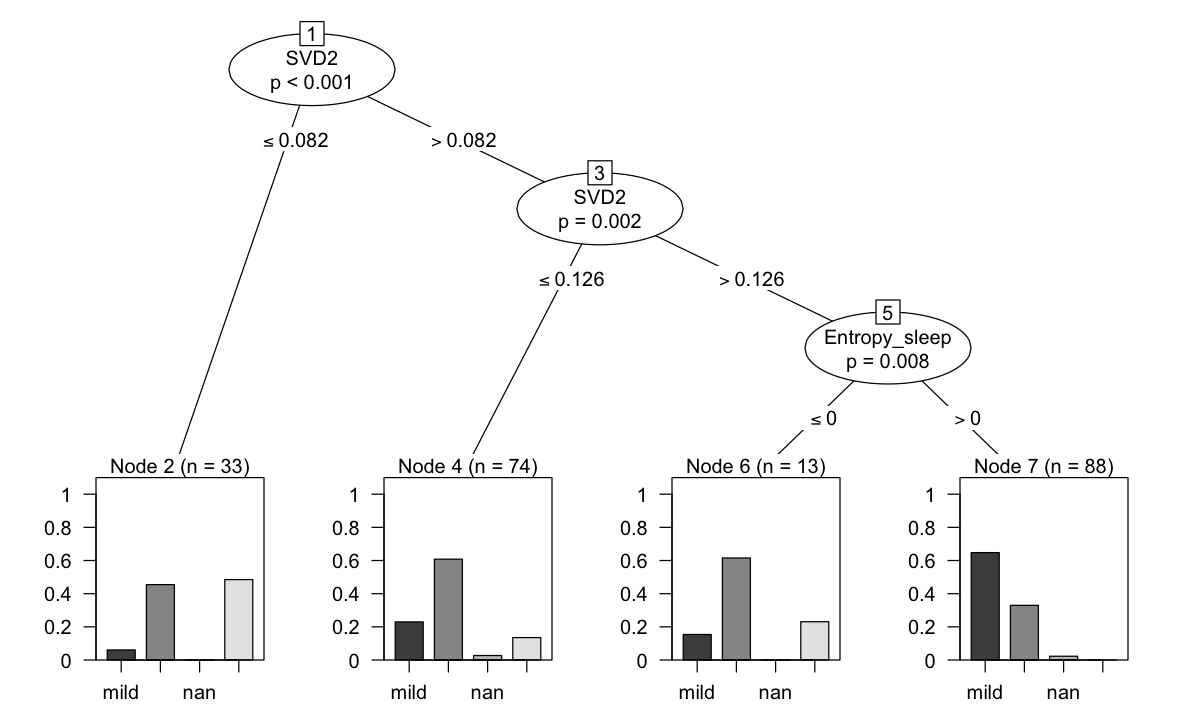

In [3]:
tree <- ctree(label ~ DFA_dt + Entropy_sleep + Entropy_tot + slope + FT_std + 
              Gini_diff + Gini_dt + Gini_t + H_complexity + H_mobility + 
              Hjorth + Hurst + Petrosian + std_DT +
              SVD2 + SVD3 + SVD5 + SVD10 + SVD15 + SVD20 + SVD25 + SVD30, data=DF)

options(repr.plot.width=10, repr.plot.height=6)
plot(tree)#, type="simple")

# There are some Stress levels not provided. Trying to obtain them via decision trees. 
pred <- predict(tree, DF[which(DF$label == 'nan'),]) 
nDF <- DF
nDF[which(DF$label == 'nan'),]$label <- pred

### Random Forest

In [7]:
# Using the randomForest package (purity measure)
# Following: http://trevorstephens.com/post/73770963794/titanic-getting-started-with-r-part-5-random
library(randomForest)

set.seed(213) # Setting a static seed will allow the results' reproducibility

# Separate sample in training and test
bound <- floor((nrow(nDF)/10)*9)                         #define % of training and test set
selectedDF <- nDF[sample(nrow(nDF),#),] #sample rows,
                   replace = TRUE), ]     #     Typically 37% will be left out
selectedDF.train <- selectedDF[1:bound, ]              #get training set
selectedDF.test <- selectedDF[(bound+1):nrow(selectedDF), ]    #get test set


# drops the empty level in the factor
selectedDF.sub <- subset(selectedDF.train, label %in% c("moderate", "mild", "severe"))
selectedDF.sub$label <- factor(selectedDF.sub$label)


fit <- randomForest(as.factor(label) ~ DFA_dt + Entropy_sleep + Entropy_tot + slope + FT_std  
                                      + Gini_diff + Gini_dt + Gini_t + H_complexity + H_mobility 
                                      + Hjorth + Hurst + Petrosian + std_DT +
              SVD2 + SVD3 + SVD5 + SVD10 + SVD15 + SVD20 + SVD25 + SVD30
                    , data=selectedDF.sub, importance=TRUE, ntree=2000)

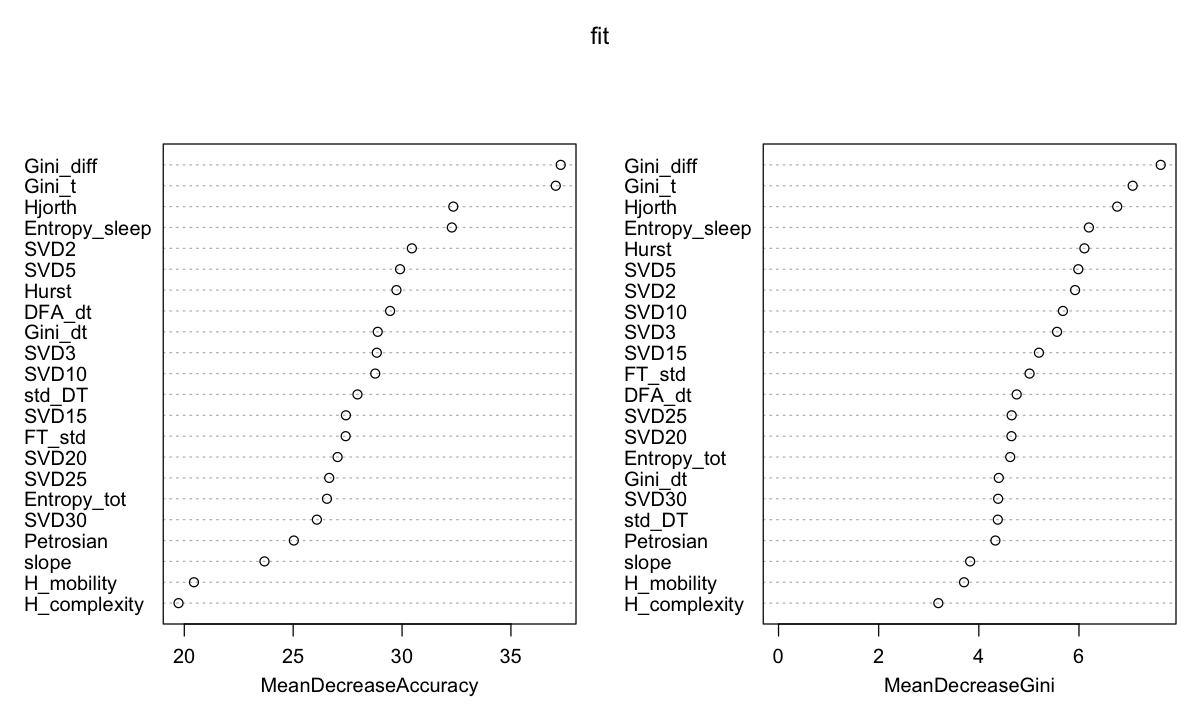

In [8]:
# Test which parameters are the most predictive (which variables are the most important)
varImpPlot(fit)

In [9]:
# Check predictions on test dataset
Prediction_RF <- predict(fit, selectedDF.test, type='response')

diff = c(Prediction_RF)-c(selectedDF.test$label)
fracLarge = sum(abs(diff) <= 1)/sum(diff > -10)*100
fracStrict = sum(abs(diff) <= 0)/sum(diff > -10)*100
print("Fraction of recognized MILD/MODERATE and MODERATE/SEVERE")
print(fracLarge)
print("Fraction of recognized MILD, MODERATE and SEVERE")
print(fracStrict)

[1] "Fraction of recognized MILD/MODERATE and MODERATE/SEVERE"
[1] 95.2381
[1] "Fraction of recognized MILD, MODERATE and SEVERE"
[1] 80.95238


In [10]:
set.seed(415)
fit <- cforest(as.factor(label) ~ DFA_dt + Entropy_sleep + Entropy_tot + slope + FT_std  
                                      + Gini_diff + Gini_dt + Gini_t + H_complexity + H_mobility 
                                      + Hjorth + Hurst + Petrosian + std_DT +
              SVD2 + SVD3 + SVD5 + SVD10 + SVD15 + SVD20 + SVD25 + SVD30,
               data = selectedDF.sub, controls=cforest_unbiased(ntree=2000, mtry=5))#mtry should be around sqrt(ncols)


In [12]:
Prediction_party <- predict(fit, selectedDF.test, OOB=TRUE, type = "response")

diff = c(Prediction_party)-c(selectedDF.test$label)
fracLarge = sum(abs(diff) <= 1)/sum(diff > -10)*100
fracStrict = sum(abs(diff) <= 0)/sum(diff > -10)*100
print("Fraction of recognized MILD/MODERATE and MODERATE/SEVERE")
print(fracLarge)
print("Fraction of recognized MILD, MODERATE and SEVERE")
print(fracStrict)

[1] "Fraction of recognized MILD/MODERATE and MODERATE/SEVERE"
[1] 100
[1] "Fraction of recognized MILD, MODERATE and SEVERE"
[1] 76.19048


#### Run 10-fold validation (or N-fold validation) for random forest

In [13]:
library(cvTools) 
k <- 10 #the number of folds

folds <- cvFolds(NROW(nDF), K=k)
nDF$holdoutpred <- rep(0,nrow(nDF))  # Array with predictions

for(i in 1:k){
    train <- nDF[folds$subsets[folds$which != i], ] #Set the training set
    validation <- nDF[folds$subsets[folds$which == i], ] #Set the validation set

    set.seed(i*1231)
    fit <- cforest(as.factor(label) ~ DFA_dt + Entropy_sleep + Entropy_tot + slope + FT_std  
                                      + Gini_diff + Gini_dt + Gini_t + H_complexity + H_mobility 
                                      + Hjorth + Hurst + Petrosian + std_DT +
              SVD2 + SVD3 + SVD5 + SVD10 + SVD15 + SVD20 + SVD25 + SVD30,
               data = train, controls=cforest_unbiased(ntree=2000, mtry=3))
    
    #Get the predicitons for the validation set (from the model just fit on the train data)
    newpred <- predict(fit, newdata=validation)
    #Put the hold out prediction in the data set for later use
    nDF[folds$subsets[folds$which == i], ]$holdoutpred <- newpred 
}

Loading required package: lattice
Loading required package: robustbase


In [14]:
# Check resulting predictions

check <- rep(0, nrow(nDF))
for(i in 1:nrow(nDF)){
    if(c(nDF$label[i])-c(nDF$holdoutpred[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF$label == 'mild'])/length(check[nDF$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF$label == 'moderate'])/length(check[nDF$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF$label == 'severe'])/length(check[nDF$label == 'severe'])
fracSevere
fracStressed = (sum(check[(nDF$label == 'severe') | (nDF$label == 'moderate')])/
                length(check[(nDF$label == 'severe') | (nDF$label == 'moderate')]))
fracStressed

[1] 0.6625

[1] 0.6868687

[1] 0.1034483

[1] 0.5546875

#### Run 10-fold validation (or N-fold validation) for Decision tree

In [15]:
library(cvTools) 
k <- 10 #the number of folds

folds <- cvFolds(NROW(nDF), K=k)
nDF$holdoutpred <- rep(0,nrow(nDF))  # Array with predictions

for(i in 1:k){
    train <- nDF[folds$subsets[folds$which != i], ] #Set the training set
    validation <- nDF[folds$subsets[folds$which == i], ] #Set the validation set

    set.seed(i*1231)
    fit <- ctree(label ~ DFA_dt + Entropy_sleep + Entropy_tot + slope + FT_std + 
              Gini_diff + Gini_dt + Gini_t + H_complexity + H_mobility + 
              Hjorth + Hurst + Petrosian + std_DT +
              SVD2 + SVD3 + SVD5 + SVD10 + SVD15 + SVD20 + SVD25 + SVD30, data=train)
    
    #Get the predicitons for the validation set (from the model just fit on the train data)
    newpred <- predict(fit, newdata=validation)
    #Put the hold out prediction in the data set for later use
    nDF[folds$subsets[folds$which == i], ]$holdoutpred <- newpred 
}

In [16]:
# Check resulting predictions

check <- rep(0, nrow(nDF))
for(i in 1:nrow(nDF)){
    if(c(nDF$label[i])-c(nDF$holdoutpred[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF$label == 'mild'])/length(check[nDF$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF$label == 'moderate'])/length(check[nDF$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF$label == 'severe'])/length(check[nDF$label == 'severe'])
fracSevere

[1] 0.675

[1] 0.5252525

[1] 0.137931

### Trying with different libraries

#### caret

In [17]:
library(caret)
library(e1071)
#remove object with NAN
nDF <- na.omit(DF)
train <- createFolds(nDF$label, k=10)

Loading required package: ggplot2


In [18]:
ctreeFit <- train(label ~ ., method = "ctree", data = nDF,
    tuneLength = 15,
    trControl = trainControl(
        method = "cv", indexOut = train))

Conditional Inference Tree 

208 samples
 24 predictor
  4 classes: 'mild', 'moderate', 'nan', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 188, 186, 188, 187, 187, 187, ... 
Resampling results across tuning parameters:

  mincriterion  Accuracy   Kappa       Accuracy SD  Kappa SD  
  0.01          0.4714069  0.01176471  0.03137963   0.03720327
  0.08          0.4714069  0.01176471  0.03137963   0.03720327
  0.15          0.4666450  0.01555556  0.04080103   0.05320973
  0.22          0.4666450  0.01555556  0.04080103   0.05320973
  0.29          0.4666450  0.01555556  0.04080103   0.05320973
  0.36          0.4666450  0.01555556  0.04080103   0.05320973
  0.43          0.4666450  0.01555556  0.04080103   0.05320973
  0.50          0.4666450  0.01555556  0.04080103   0.05320973
  0.57          0.4666450  0.01555556  0.04080103   0.05320973
  0.64          0.4666450  0.01555556  0.04080103   0.05320973
  0.71          0.4666450  0.01555556 

[1] moderate moderate moderate moderate moderate moderate moderate moderate
 [9] moderate moderate
Levels: mild moderate nan severe

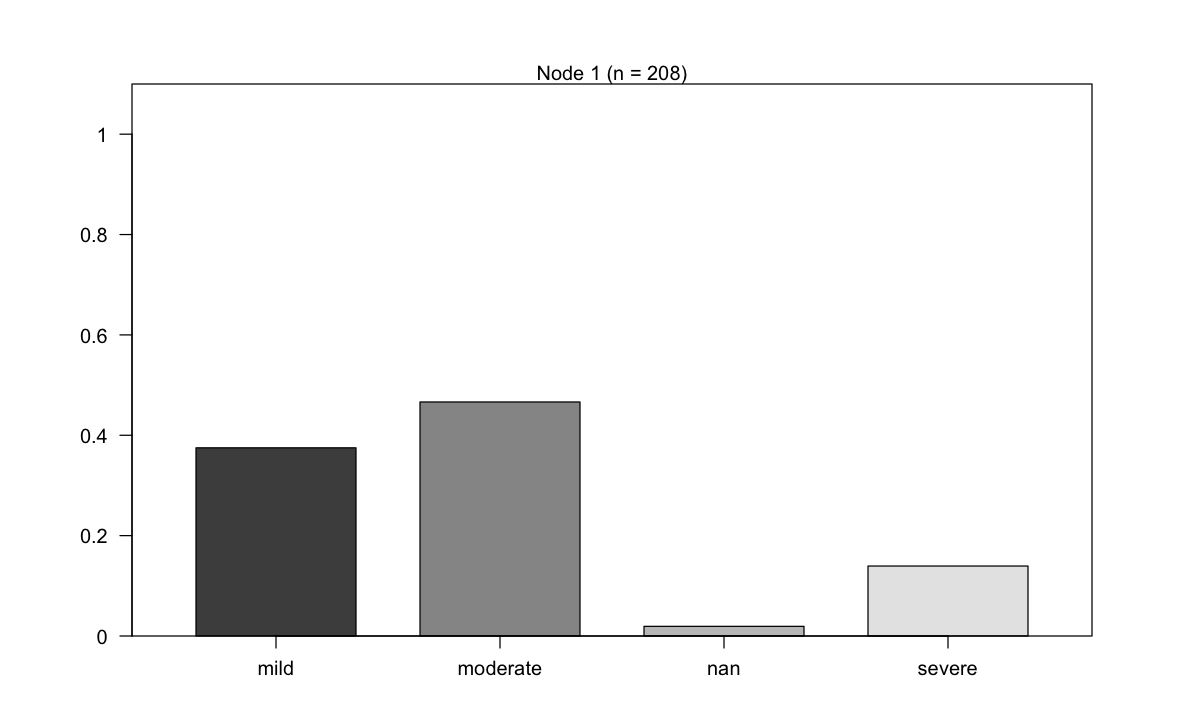

In [19]:
ctreeFit
plot(ctreeFit$finalModel)
predict(ctreeFit, nDF[1:10,])

#### RWeka

In [20]:
library(RWeka)

set.seed(218651) 
C45Fit <- train(label ~ ., method = "J48", data = nDF,
    tuneLength = 5,
    trControl = trainControl(
        method = "cv", indexOut = train))
C45Fit
C45Fit$finalModel

C4.5-like Trees 

208 samples
 24 predictor
  4 classes: 'mild', 'moderate', 'nan', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 188, 187, 187, 187, 187, 188, ... 
Resampling results

  Accuracy   Kappa      Accuracy SD  Kappa SD 
  0.8358874  0.7319366  0.07769868   0.1231821

Tuning parameter 'C' was held constant at a value of 0.25
 

J48 pruned tree
------------------

SVD2 <= 0.103778
|   std_DT <= 0.112652
|   |   SVD2 <= 0.079827
|   |   |   SVD3 <= 0.131135: moderate (21.0/6.0)
|   |   |   SVD3 > 0.131135: severe (5.0)
|   |   SVD2 > 0.079827
|   |   |   SVD2 <= 0.085466: mild (2.0)
|   |   |   SVD2 > 0.085466
|   |   |   |   DFA_dt <= 1.600057
|   |   |   |   |   Gini_diff <= 0.000603
|   |   |   |   |   |   FT_std <= 0.372689: severe (3.0)
|   |   |   |   |   |   FT_std > 0.372689: moderate (2.0)
|   |   |   |   |   Gini_diff > 0.000603: moderate (15.0/1.0)
|   |   |   |   DFA_dt > 1.600057: mild (4.0/2.0)
|   std_DT > 0.112652: severe (8.0/1.0)
SVD2 > 0.103778
|   Entropy_sleep <= 0.04436
|   |   DFA_dt <= 0.820075
|   |   |   H_complexity <= 289.702068
|   |   |   |   X <= 70
|   |   |   |   |   Gini_diff <= 0.001869: moderate (2.0)
|   |   |   |   |   Gini_diff > 0.001869: mild (2.0)
|   |   |   |   X > 70
|   |   |   |   |   DFA_dt <= 0.513497: mild (3.0/1.0)
|   |   |   |   |   DFA_dt > 0.513497: severe 

In [22]:
# Check resulting predictions
predictedC45 <- predict(C45Fit, nDF)
check <- rep(0, nrow(nDF))
for(i in 1:nrow(nDF)){
    if(c(nDF$label[i])-c(predictedC45[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF$label == 'mild'])/length(check[nDF$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF$label == 'moderate'])/length(check[nDF$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF$label == 'severe'])/length(check[nDF$label == 'severe'])
fracSevere

[1] 0.9358974

[1] 0.9587629

[1] 0.6896552

In [25]:
# PART (Rule-based classifier)
rulesFit <- train(label ~ ., method = "PART", data = nDF,
  tuneLength = 5,
  trControl = trainControl(
    method = "cv", indexOut = train))
rulesFit
rulesFit$finalModel

Rule-Based Classifier 

208 samples
 24 predictor
  4 classes: 'mild', 'moderate', 'nan', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 187, 187, 187, 188, 188, 187, ... 
Resampling results

  Accuracy   Kappa      Accuracy SD  Kappa SD 
  0.8459307  0.7473105  0.07759047   0.1259121

Tuning parameter 'threshold' was held constant at a value of 0.25

Tuning parameter 'pruned' was held constant at a value of yes
 

PART decision list
------------------

SVD2 <= 0.103778 AND
std_DT <= 0.112652 AND
SVD2 <= 0.079827 AND
SVD3 <= 0.131135: moderate (21.0/6.0)

SVD3 <= 0.146439 AND
Hurst <= 0.80193: severe (9.0)

Entropy_sleep > 0.066688 AND
Gini_diff <= 0.003986 AND
slope <= 0.001655: mild (28.0/1.0)

Petrosian <= 0.571264 AND
Hjorth <= 0.796696 AND
Gini_t > 0.030874 AND
Petrosian > 0.563203: moderate (21.0)

Petrosian <= 0.571264 AND
std_DT > 0.045356 AND
Entropy_sleep > 0.042438: mild (49.0/21.0)

SVD2 > 0.117814 AND
H_complexity <= 358.062814 AND
Entropy_sleep > -0.000421 AND
FT_std <= 0.387787 AND
X > 48 AND
Gini_diff > -0.011331 AND
Gini_dt <= 0.050976 AND
Entropy_sleep > 0.030404: moderate (8.0/1.0)

SVD2 > 0.118913 AND
Gini_t > 0.042898 AND
Hurst > 0.685309 AND
Hurst <= 0.775342 AND
Hjorth <= 0.860456: moderate (14.0/1.0)

SVD2 > 0.118913 AND
Entropy_sleep > -0.000421 AND
H_complexity <= 382.589065: mild (18.0/1.0)

FT_std <= 0.327191 AND
slope <= 0.013519 AND
DFA_dt <= 1.019292: moderate (7.0)

In [26]:
# Check resulting predictions
predictedRules <- predict(rulesFit, nDF)
check <- rep(0, nrow(nDF))
for(i in 1:nrow(nDF)){
    if(c(nDF$label[i])-c(predictedRules[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF$label == 'mild'])/length(check[nDF$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF$label == 'moderate'])/length(check[nDF$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF$label == 'severe'])/length(check[nDF$label == 'severe'])
fracSevere

[1] 0.974359

[1] 0.7628866

[1] 0.7586207

In [27]:
# Linear Support Vector Machines
svmFit <- train(label ~., method = "svmLinear", data = nDF,
    tuneLength = 5,
    trControl = trainControl(
        method = "cv", indexOut = train))
svmFit
svmFit$finalModel

Loading required package: kernlab

Attaching package: ‘kernlab’

The following object is masked from ‘package:modeltools’:

    prior

Warning message:
In .local(x, ...): Variable(s) `' constant. Cannot scale data.Warning message:
In .local(x, ...): Variable(s) `' constant. Cannot scale data.Warning message:
In .local(x, ...): Variable(s) `' constant. Cannot scale data.Warning message:
In .local(x, ...): Variable(s) `' constant. Cannot scale data.Warning message:
In .local(x, ...): Variable(s) `' constant. Cannot scale data.Warning message:
In .local(x, ...): Variable(s) `' constant. Cannot scale data.Warning message:
In .local(x, ...): Variable(s) `' constant. Cannot scale data.Warning message:
In .local(x, ...): Variable(s) `' constant. Cannot scale data.Warning message:
In .local(x, ...): Variable(s) `' constant. Cannot scale data.Warning message:
In .local(x, ...): Variable(s) `' constant. Cannot scale data.

Support Vector Machines with Linear Kernel 

208 samples
 24 predictor
  4 classes: 'mild', 'moderate', 'nan', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 188, 186, 187, 186, 189, 186, ... 
Resampling results

  Accuracy   Kappa      Accuracy SD  Kappa SD  
  0.9371429  0.8958813  0.05634585   0.09373028

Tuning parameter 'C' was held constant at a value of 1
 

Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 1 

Linear (vanilla) kernel function. 

Number of Support Vectors : 207 

Objective Function Value : -0.3522 -0.035 -0.128 -0.036 -0.1876 -0.0304 
Training error : 0 

In [28]:
# Check resulting predictions
predictedSVM <- predict(svmFit, nDF)
check <- rep(0, nrow(nDF))
for(i in 1:nrow(nDF)){
    if(c(nDF$label[i])-c(predictedSVM[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF$label == 'mild'])/length(check[nDF$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF$label == 'moderate'])/length(check[nDF$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF$label == 'severe'])/length(check[nDF$label == 'severe'])
fracSevere

[1] 1

[1] 1

[1] 1

In [29]:
# Artificial Neural Network
nnetFit <- train(label ~ ., method = "nnet", data = nDF,
    tuneLength = 5,
    trControl = trainControl(
        method = "cv"
        , indexOut = train))
nnetFit
nnetFit$finalModel

Loading required package: nnet


# weights:  239
initial  value 289.587147 
iter  10 value 202.032956
final  value 202.032951 
converged
# weights:  709
initial  value 338.169234 
iter  10 value 196.627604
iter  20 value 195.056969
iter  30 value 193.912082
iter  40 value 191.811776
iter  50 value 191.307047
iter  60 value 191.296647
final  value 191.296618 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=5, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=7, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=9, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 298.762952 
iter  10 value 202.611629
iter  20 value 202.360735
iter  30 value 201.436252
iter  40 value 199.947074
iter  50 value 199.775348
iter  50 value 199.775347
iter  50 value 199.775347
final  value 199.775347 
converged
# weights:  709
initial  value 239.131350 
iter  10 value 202.057305
iter  20 value 199.331055
iter  30 value 187.367365
iter  40 value 176.605737
iter  50 value 121.621388
iter  60 value 105.839548
iter  70 value 97.824740
iter  80 value 90.130950
iter  90 value 80.591038
iter 100 value 73.468073
final  value 73.468073 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=5, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=7, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=9, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 290.610192 
iter  10 value 198.976914
iter  20 value 198.453790
iter  30 value 198.426484
iter  40 value 198.425587
final  value 198.425582 
converged
# weights:  709
initial  value 332.320483 
iter  10 value 202.825949
iter  20 value 198.733312
iter  30 value 198.116442
iter  40 value 196.082314
iter  50 value 174.122914
iter  60 value 154.382277
iter  70 value 76.024694
iter  80 value 34.667412
iter  90 value 29.464980
iter 100 value 28.878467
final  value 28.878467 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=5, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=7, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=9, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 258.474014 
iter  10 value 202.313426
iter  20 value 202.254079
iter  30 value 202.056696
iter  40 value 202.036149
final  value 202.035920 
converged
# weights:  709
initial  value 237.229500 
iter  10 value 202.158021
iter  20 value 202.000460
iter  30 value 197.903311
iter  40 value 121.344195
iter  50 value 72.916191
iter  60 value 45.292598
iter  70 value 38.023361
iter  80 value 32.056916
iter  90 value 24.460842
iter 100 value 19.317155
final  value 19.317155 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=5, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=7, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=9, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 218.519779 
final  value 202.037529 
converged
# weights:  709
initial  value 246.643465 
iter  10 value 202.044517
iter  20 value 202.035423
iter  30 value 201.975201
iter  40 value 197.508200
iter  50 value 169.863483
iter  60 value 95.384044
iter  70 value 82.554465
iter  80 value 73.302836
iter  90 value 66.344450
iter 100 value 61.138634
final  value 61.138634 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=5, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=7, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold01: size=9, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 242.463841 
final  value 202.032951 
converged
# weights:  709
initial  value 229.689099 
iter  10 value 200.762743
iter  20 value 197.458209
iter  30 value 197.295155
iter  40 value 197.011630
iter  50 value 196.943748
iter  60 value 196.936373
iter  70 value 196.935384
final  value 196.935252 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=5, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=7, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=9, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 247.139457 
iter  10 value 202.618494
iter  20 value 202.405279
iter  30 value 201.620920
iter  40 value 183.435909
iter  50 value 116.330585
iter  60 value 99.685866
iter  70 value 98.354915
final  value 98.353308 
converged
# weights:  709
initial  value 390.574517 
iter  10 value 202.274232
iter  20 value 195.700477
iter  30 value 167.474638
iter  40 value 112.972528
iter  50 value 86.643010
iter  60 value 80.974077
iter  70 value 76.355958
iter  80 value 68.406429
iter  90 value 66.805042
iter 100 value 65.807797
final  value 65.807797 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=5, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=7, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=9, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 219.169449 
iter  10 value 202.084212
iter  20 value 200.697902
iter  30 value 197.835299
iter  40 value 197.795569
iter  50 value 197.792049
iter  60 value 197.788895
final  value 197.787998 
converged
# weights:  709
initial  value 263.515753 
iter  10 value 202.924036
iter  20 value 201.575835
iter  30 value 192.554384
iter  40 value 102.861974
iter  50 value 46.645130
iter  60 value 31.780244
iter  70 value 29.701469
iter  80 value 29.117192
iter  90 value 29.084095
iter 100 value 29.036373
final  value 29.036373 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=5, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=7, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=9, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 326.156451 
iter  10 value 202.073933
iter  20 value 202.036033
final  value 202.035920 
converged
# weights:  709
initial  value 320.527064 
iter  10 value 202.612201
iter  20 value 200.765340
iter  30 value 200.525487
iter  40 value 200.441390
iter  50 value 200.418283
iter  60 value 200.278899
iter  70 value 198.077036
iter  80 value 185.952007
iter  90 value 160.698673
iter 100 value 91.616725
final  value 91.616725 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=5, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=7, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=9, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 322.295549 
iter  10 value 202.042425
final  value 202.037136 
converged
# weights:  709
initial  value 353.890226 
iter  10 value 201.592143
iter  20 value 200.469547
iter  30 value 200.154192
iter  40 value 200.147657
iter  50 value 200.050581
iter  60 value 200.003249
iter  70 value 199.983903
iter  80 value 199.982986
iter  90 value 199.973956
iter 100 value 199.972472
final  value 199.972472 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=5, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=7, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold02: size=9, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 314.958114 
iter  10 value 199.026701
final  value 199.026687 
converged
# weights:  709
initial  value 246.862549 
iter  10 value 199.108988
final  value 199.026687 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=5, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=7, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=9, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 254.908539 
iter  10 value 199.773070
iter  20 value 199.122681
iter  30 value 192.419194
iter  40 value 140.311817
iter  50 value 97.040779
iter  60 value 93.482460
iter  70 value 93.481892
iter  70 value 93.481891
iter  70 value 93.481891
final  value 93.481891 
converged
# weights:  709
initial  value 344.959291 
iter  10 value 200.818896
iter  20 value 199.728308
iter  30 value 198.659039
iter  40 value 190.983205
iter  50 value 161.101162
iter  60 value 129.109101
iter  70 value 109.689047
iter  80 value 101.813576
iter  90 value 90.240396
iter 100 value 89.433802
final  value 89.433802 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=5, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=7, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=9, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 270.514877 
iter  10 value 197.431829
iter  20 value 194.991454
iter  30 value 193.290509
iter  40 value 87.079957
iter  50 value 52.037314
iter  60 value 38.339905
iter  70 value 30.093195
iter  80 value 28.166757
iter  90 value 28.071624
iter 100 value 28.061376
final  value 28.061376 
stopped after 100 iterations
# weights:  709
initial  value 261.490038 
iter  10 value 199.732123
iter  20 value 199.223667
iter  30 value 190.151863
iter  40 value 156.135310
iter  50 value 130.142547
iter  60 value 61.776387
iter  70 value 37.547045
iter  80 value 31.089003
iter  90 value 28.481834
iter 100 value 27.548363
final  value 27.548363 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=5, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=7, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=9, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 355.145156 
iter  10 value 199.065996
iter  20 value 198.763857
iter  30 value 194.543041
iter  40 value 194.520896
final  value 194.520795 
converged
# weights:  709
initial  value 313.804318 
iter  10 value 195.375343
iter  20 value 194.633748
iter  30 value 194.527415
iter  40 value 194.515683
iter  50 value 194.401120
iter  60 value 192.960205
iter  70 value 127.945807
iter  80 value 66.511510
iter  90 value 45.870460
iter 100 value 38.851475
final  value 38.851475 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=5, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=7, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=9, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 305.524440 
iter  10 value 194.693495
iter  20 value 194.466214
iter  30 value 194.464816
iter  40 value 194.462388
iter  50 value 194.461574
final  value 194.461404 
converged
# weights:  709
initial  value 321.481706 
iter  10 value 199.038668
iter  20 value 198.513686
iter  30 value 194.355260
iter  40 value 180.681438
iter  50 value 104.920989
iter  60 value 44.919412
iter  70 value 16.652576
iter  80 value 16.180816
iter  90 value 15.239154
iter 100 value 11.568085
final  value 11.568085 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=5, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=7, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold03: size=9, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 221.815621 
iter  10 value 203.778587
iter  10 value 203.778587
iter  10 value 203.778587
final  value 203.778587 
converged
# weights:  709
initial  value 252.980377 
final  value 203.778587 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=5, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=7, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=9, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 352.554288 
iter  10 value 206.549694
iter  20 value 204.310350
iter  30 value 202.448390
iter  40 value 202.427711
final  value 202.422624 
converged
# weights:  709
initial  value 300.685240 
iter  10 value 203.599029
iter  20 value 201.406182
iter  30 value 200.581781
iter  40 value 200.158289
iter  50 value 192.121380
iter  60 value 137.266495
iter  70 value 105.369075
iter  80 value 96.277910
iter  90 value 94.837398
iter 100 value 93.993963
final  value 93.993963 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=5, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=7, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=9, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 252.633678 
iter  10 value 204.067685
iter  20 value 202.631302
iter  30 value 202.088955
iter  40 value 201.768552
iter  50 value 201.680271
iter  60 value 201.622954
iter  70 value 201.368393
iter  80 value 201.352971
final  value 201.352664 
converged
# weights:  709
initial  value 419.374416 
iter  10 value 200.698874
iter  20 value 197.888696
iter  30 value 197.008919
iter  40 value 153.371492
iter  50 value 84.466477
iter  60 value 54.066542
iter  70 value 33.418860
iter  80 value 30.203668
iter  90 value 28.862968
iter 100 value 28.778172
final  value 28.778172 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=5, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=7, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=9, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 281.487448 
iter  10 value 199.462286
iter  20 value 199.272839
iter  30 value 199.246180
iter  40 value 199.243164
final  value 199.241815 
converged
# weights:  709
initial  value 367.840957 
iter  10 value 206.731599
iter  20 value 203.873512
iter  30 value 202.905373
iter  40 value 202.178566
iter  50 value 202.112148
iter  60 value 201.605055
iter  70 value 201.586365
iter  80 value 201.319542
iter  90 value 200.936806
iter 100 value 200.928822
final  value 200.928822 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=5, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=7, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=9, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 250.152909 
iter  10 value 203.782877
iter  20 value 203.779277
final  value 203.778887 
converged
# weights:  709
initial  value 321.244167 
iter  10 value 203.790658
iter  20 value 203.642169
iter  30 value 202.333780
iter  40 value 184.464865
iter  50 value 75.728694
iter  60 value 40.186766
iter  70 value 33.226822
iter  80 value 31.485259
iter  90 value 28.985504
iter 100 value 26.245951
final  value 26.245951 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=5, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=7, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold04: size=9, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 276.325481 
iter  10 value 198.810662
final  value 198.810658 
converged
# weights:  709
initial  value 235.553938 
iter  10 value 198.810658
iter  10 value 198.810658
iter  10 value 198.810658
final  value 198.810658 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=5, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=7, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=9, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 244.055561 
iter  10 value 199.481600
iter  20 value 196.865891
iter  30 value 195.903746
final  value 195.903351 
converged
# weights:  709
initial  value 343.988662 
iter  10 value 208.630483
iter  20 value 198.279774
iter  30 value 193.304501
iter  40 value 191.988473
iter  50 value 191.621731
iter  60 value 191.599008
iter  70 value 191.596607
iter  80 value 191.596501
iter  80 value 191.596499
iter  80 value 191.596499
final  value 191.596499 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=5, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=7, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=9, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 295.679581 
iter  10 value 199.293396
iter  20 value 198.914958
iter  30 value 198.675758
iter  40 value 197.722376
iter  50 value 197.698742
iter  60 value 197.693638
iter  70 value 195.962449
iter  80 value 194.550879
iter  90 value 194.527935
iter 100 value 194.526329
final  value 194.526329 
stopped after 100 iterations
# weights:  709
initial  value 337.181668 
iter  10 value 205.808517
iter  20 value 198.914162
iter  30 value 195.435850
iter  40 value 192.457686
iter  50 value 191.774057
iter  60 value 189.621455
iter  70 value 183.706766
iter  80 value 92.930857
iter  90 value 25.322029
iter 100 value 14.414260
final  value 14.414260 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=5, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=7, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=9, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 283.657301 
iter  10 value 198.855554
iter  20 value 198.819434
iter  30 value 197.054937
iter  40 value 193.548190
iter  50 value 193.021808
iter  60 value 192.286137
iter  70 value 190.908220
iter  80 value 151.534294
iter  90 value 41.096060
iter 100 value 17.253860
final  value 17.253860 
stopped after 100 iterations
# weights:  709
initial  value 277.816374 
iter  10 value 194.539897
iter  20 value 194.406126
iter  30 value 194.329859
iter  40 value 194.254224
iter  50 value 190.935461
iter  60 value 186.745327
iter  70 value 186.565484
iter  80 value 186.479750
iter  90 value 186.134051
iter 100 value 178.215838
final  value 178.215838 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=5, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=7, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=9, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 218.991382 
final  value 198.815516 
converged
# weights:  709
initial  value 236.846120 
iter  10 value 196.161715
iter  20 value 194.693589
iter  30 value 194.567420
iter  40 value 194.493951
iter  50 value 194.483304
iter  60 value 194.476672
iter  70 value 194.467333
iter  80 value 194.441167
iter  90 value 194.372658
iter 100 value 194.041137
final  value 194.041137 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=5, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=7, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold05: size=9, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 294.835895 
iter  10 value 203.989765
final  value 203.989643 
converged
# weights:  709
initial  value 279.405828 
iter  10 value 203.989643
iter  10 value 203.989643
iter  10 value 203.989643
final  value 203.989643 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=5, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=7, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=9, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 258.218948 
iter  10 value 204.285862
iter  20 value 203.186735
iter  30 value 197.040771
iter  40 value 174.410424
iter  50 value 114.889406
iter  60 value 100.116816
iter  70 value 97.872890
iter  80 value 97.807182
final  value 97.807102 
converged
# weights:  709
initial  value 348.932227 
iter  10 value 210.083887
iter  20 value 202.154671
iter  30 value 201.632998
iter  40 value 199.002105
iter  50 value 198.645316
iter  60 value 198.552469
iter  70 value 198.490125
iter  80 value 197.246054
iter  90 value 178.112921
iter 100 value 119.897802
final  value 119.897802 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=5, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=7, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=9, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 379.874988 
iter  10 value 204.753526
iter  20 value 204.362193
iter  30 value 204.013577
iter  40 value 201.505585
iter  50 value 201.215207
iter  60 value 201.206793
final  value 201.206781 
converged
# weights:  709
initial  value 266.916360 
iter  10 value 201.584525
iter  20 value 199.791436
iter  30 value 199.753156
iter  40 value 199.642514
iter  50 value 198.314936
iter  60 value 198.099341
iter  70 value 198.035402
iter  80 value 197.932613
iter  90 value 197.896958
iter 100 value 197.888728
final  value 197.888728 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=5, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=7, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=9, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 298.734719 
iter  10 value 204.034738
iter  20 value 202.618235
iter  30 value 201.568599
iter  40 value 201.239200
iter  50 value 201.049933
iter  60 value 200.984499
iter  70 value 200.948277
iter  80 value 200.945201
final  value 200.944896 
converged
# weights:  709
initial  value 367.843580 
iter  10 value 204.104156
iter  20 value 203.982186
iter  30 value 202.452864
iter  40 value 202.089578
iter  50 value 202.085855
iter  60 value 200.907552
iter  70 value 199.814390
iter  80 value 199.808086
iter  90 value 199.806922
final  value 199.806677 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=5, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=7, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=9, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 327.297342 
iter  10 value 203.997554
iter  10 value 203.997553
iter  10 value 203.997553
final  value 203.997553 
converged
# weights:  709
initial  value 252.282165 
iter  10 value 203.612181
iter  20 value 198.783178
iter  30 value 198.342291
iter  40 value 197.740086
iter  50 value 194.731031
iter  60 value 171.393927
iter  70 value 117.991330
iter  80 value 51.191959
iter  90 value 49.179185
iter 100 value 47.693630
final  value 47.693630 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=5, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=7, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold06: size=9, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 302.613583 
iter  10 value 202.032977
final  value 202.032951 
converged
# weights:  709
initial  value 275.447918 
iter  10 value 206.575097
iter  20 value 199.555394
iter  30 value 199.435553
final  value 199.435263 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=5, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=7, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=9, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 239.807794 
iter  10 value 202.479031
iter  20 value 202.344347
iter  30 value 200.254157
iter  40 value 199.033691
final  value 199.027072 
converged
# weights:  709
initial  value 338.619254 
iter  10 value 202.616622
iter  20 value 201.361766
iter  30 value 199.345429
iter  40 value 198.649059
iter  50 value 197.588404
iter  60 value 197.497439
iter  70 value 197.488083
iter  70 value 197.488082
iter  70 value 197.488082
final  value 197.488082 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=5, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=7, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=9, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 301.137614 
iter  10 value 202.371438
iter  20 value 202.088988
iter  30 value 202.065975
iter  40 value 200.662105
iter  50 value 197.836657
iter  60 value 197.818368
final  value 197.818281 
converged
# weights:  709
initial  value 228.829801 
iter  10 value 201.677999
iter  20 value 197.983060
iter  30 value 197.757881
iter  40 value 197.711607
iter  50 value 197.706043
iter  60 value 197.704869
iter  70 value 197.703891
iter  80 value 197.156142
iter  90 value 194.498682
iter 100 value 192.877339
final  value 192.877339 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=5, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=7, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=9, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 294.387537 
iter  10 value 202.078285
iter  20 value 202.035256
iter  30 value 201.831538
iter  40 value 199.809377
iter  50 value 69.501137
iter  60 value 30.582374
iter  70 value 27.868400
iter  80 value 25.320711
iter  90 value 8.798152
iter 100 value 7.679488
final  value 7.679488 
stopped after 100 iterations
# weights:  709
initial  value 310.701987 
iter  10 value 202.181955
iter  20 value 201.814353
iter  30 value 198.970401
iter  40 value 191.169631
iter  50 value 191.142264
iter  60 value 191.107858
iter  70 value 190.983742
iter  80 value 188.960814
iter  90 value 139.863603
iter 100 value 54.003219
final  value 54.003219 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=5, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=7, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=9, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 316.571916 
iter  10 value 202.037451
iter  20 value 202.034231
iter  30 value 202.013359
iter  40 value 200.257824
iter  50 value 199.564604
iter  60 value 199.538207
iter  70 value 199.536096
iter  80 value 199.532505
iter  90 value 199.529837
iter 100 value 199.527513
final  value 199.527513 
stopped after 100 iterations
# weights:  709
initial  value 374.843186 
iter  10 value 202.050953
iter  20 value 202.039160
iter  30 value 200.241269
iter  40 value 199.722790
iter  50 value 199.511325
iter  60 value 199.506114
iter  70 value 199.505447
iter  80 value 199.501903
final  value 199.501680 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=5, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=7, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold07: size=9, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 286.304848 
final  value 198.053861 
converged
# weights:  709
initial  value 270.954899 
iter  10 value 195.943682
iter  20 value 195.112325
iter  30 value 194.757434
iter  40 value 194.703711
iter  50 value 194.697907
iter  60 value 194.697140
iter  70 value 194.697035
iter  70 value 194.697033
iter  70 value 194.697033
final  value 194.697033 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=5, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=7, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=9, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 251.289700 
iter  10 value 198.687207
iter  20 value 198.448659
iter  30 value 198.402251
iter  40 value 198.401805
iter  40 value 198.401803
iter  40 value 198.401803
final  value 198.401803 
converged
# weights:  709
initial  value 276.926552 
iter  10 value 197.091995
iter  20 value 195.976612
iter  30 value 191.480561
iter  40 value 154.686156
iter  50 value 112.668069
iter  60 value 93.093817
iter  70 value 92.029578
iter  80 value 91.923615
iter  90 value 91.906123
iter 100 value 91.905076
final  value 91.905076 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=5, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=7, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=9, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 311.982237 
iter  10 value 203.852070
iter  20 value 201.408094
iter  30 value 198.123291
iter  40 value 197.089614
iter  50 value 196.660476
iter  60 value 195.710688
iter  70 value 156.961000
iter  80 value 57.615264
iter  90 value 32.610318
iter 100 value 29.490256
final  value 29.490256 
stopped after 100 iterations
# weights:  709
initial  value 327.074480 
iter  10 value 198.653014
iter  20 value 198.126069
iter  30 value 197.486669
iter  40 value 194.370278
iter  50 value 186.640854
iter  60 value 88.150622
iter  70 value 57.041020
iter  80 value 34.817241
iter  90 value 31.144133
iter 100 value 28.623531
final  value 28.623531 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=5, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=7, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=9, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 270.855612 
iter  10 value 198.124543
iter  20 value 198.082860
iter  30 value 198.063556
final  value 198.060956 
converged
# weights:  709
initial  value 362.933882 
iter  10 value 199.273359
iter  20 value 199.004581
iter  30 value 198.461324
iter  40 value 197.436752
iter  50 value 197.158823
iter  60 value 196.821156
iter  70 value 196.477792
iter  80 value 196.462811
iter  90 value 196.367813
iter 100 value 194.919966
final  value 194.919966 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=5, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=7, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=9, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 233.272163 
iter  10 value 198.058287
iter  20 value 198.041972
iter  30 value 197.369906
iter  40 value 189.446254
iter  50 value 159.305938
iter  60 value 158.285947
iter  70 value 156.883113
iter  80 value 156.754825
iter  90 value 156.681527
iter 100 value 156.477478
final  value 156.477478 
stopped after 100 iterations
# weights:  709
initial  value 293.543678 
iter  10 value 198.065789
iter  20 value 198.055219
iter  30 value 198.054504
final  value 198.054498 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=5, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=7, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold08: size=9, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 282.715382 
iter  10 value 198.810658
iter  10 value 198.810658
iter  10 value 198.810658
final  value 198.810658 
converged
# weights:  709
initial  value 278.028880 
iter  10 value 198.810753
final  value 198.810667 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=5, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=7, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=9, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 272.557861 
iter  10 value 199.498576
iter  20 value 198.837737
iter  30 value 186.091136
iter  40 value 156.613966
iter  50 value 146.155197
iter  60 value 120.084163
iter  70 value 94.153854
iter  80 value 93.862959
final  value 93.862563 
converged
# weights:  709
initial  value 278.924254 
iter  10 value 207.671501
iter  20 value 195.892791
iter  30 value 193.490617
iter  40 value 177.079774
iter  50 value 151.197092
iter  60 value 137.665106
iter  70 value 97.585505
iter  80 value 67.961471
iter  90 value 64.214468
iter 100 value 63.481320
final  value 63.481320 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=5, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=7, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=9, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 243.835381 
iter  10 value 199.123422
iter  20 value 198.881565
iter  30 value 198.119344
iter  40 value 196.440326
iter  50 value 182.128595
iter  60 value 89.082930
iter  70 value 49.234991
iter  80 value 31.290135
iter  90 value 28.225750
iter 100 value 27.875586
final  value 27.875586 
stopped after 100 iterations
# weights:  709
initial  value 210.026997 
iter  10 value 199.416448
iter  20 value 194.880567
iter  30 value 194.615187
iter  40 value 194.585411
iter  50 value 194.236708
iter  60 value 192.135855
iter  70 value 185.060759
iter  80 value 179.710255
iter  90 value 60.329929
iter 100 value 32.158919
final  value 32.158919 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=5, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=7, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=9, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 319.021881 
iter  10 value 198.854347
iter  20 value 198.817620
iter  30 value 198.655945
iter  40 value 197.277478
iter  50 value 197.250218
iter  60 value 197.237329
iter  70 value 197.232444
iter  80 value 197.231408
final  value 197.231113 
converged
# weights:  709
initial  value 287.584208 
iter  10 value 198.929755
iter  20 value 198.440794
iter  30 value 194.367126
iter  40 value 193.417127
iter  50 value 174.617714
iter  60 value 90.009606
iter  70 value 23.320632
iter  80 value 15.257314
iter  90 value 10.859421
iter 100 value 8.625937
final  value 8.625937 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=5, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=7, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=9, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 219.521950 
final  value 198.814851 
converged
# weights:  709
initial  value 318.618456 
iter  10 value 198.097608
iter  20 value 194.296607
iter  30 value 194.264469
iter  40 value 193.976417
iter  50 value 189.061070
iter  60 value 120.112321
iter  70 value 76.217813
iter  80 value 56.613355
iter  90 value 19.448727
iter 100 value 10.806584
final  value 10.806584 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=5, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=7, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold09: size=9, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 254.401288 
iter  10 value 202.032958
final  value 202.032951 
converged
# weights:  709
initial  value 250.826174 
iter  10 value 202.032913
iter  20 value 202.032708
iter  30 value 201.698910
iter  40 value 194.629558
iter  50 value 185.777071
iter  60 value 172.579085
iter  70 value 80.520284
iter  80 value 31.553143
iter  90 value 28.391550
iter 100 value 27.980224
final  value 27.980224 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=5, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=7, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=9, decay=0e+00 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 236.985266 
iter  10 value 202.603831
iter  20 value 201.623752
iter  30 value 198.910208
iter  40 value 163.165002
iter  50 value 116.991894
iter  60 value 104.059200
iter  70 value 103.282944
final  value 103.282717 
converged
# weights:  709
initial  value 263.112838 
iter  10 value 202.341195
iter  20 value 201.629662
iter  30 value 200.977481
iter  40 value 199.581024
iter  50 value 172.584583
iter  60 value 121.201882
iter  70 value 104.661485
iter  80 value 101.441715
iter  90 value 97.994729
iter 100 value 94.863413
final  value 94.863413 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=5, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=7, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=9, decay=1e-01 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 298.653893 
iter  10 value 202.370988
iter  20 value 201.254763
iter  30 value 200.864390
iter  40 value 200.791531
iter  50 value 200.744761
final  value 200.744537 
converged
# weights:  709
initial  value 286.188839 
iter  10 value 202.522355
iter  20 value 200.824596
iter  30 value 198.119346
iter  40 value 116.058645
iter  50 value 84.629427
iter  60 value 51.890172
iter  70 value 24.155798
iter  80 value 19.873230
iter  90 value 19.197067
iter 100 value 17.984100
final  value 17.984100 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=5, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=7, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=9, decay=1e-02 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 254.604472 
iter  10 value 202.078481
iter  20 value 202.038487
iter  30 value 201.772655
iter  40 value 197.951923
iter  50 value 170.212858
iter  60 value 164.047446
iter  70 value 160.383087
iter  80 value 159.234235
iter  90 value 157.667201
iter 100 value 156.619666
final  value 156.619666 
stopped after 100 iterations
# weights:  709
initial  value 256.148363 
iter  10 value 202.146710
iter  20 value 201.433413
iter  30 value 199.319797
iter  40 value 199.211556
iter  50 value 199.210171
iter  50 value 199.210170
iter  50 value 199.210170
final  value 199.210170 
converged


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=5, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=7, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=9, decay=1e-03 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights


# weights:  239
initial  value 283.042085 
final  value 202.038462 
converged
# weights:  709
initial  value 362.948466 
iter  10 value 202.046285
iter  20 value 202.005164
iter  30 value 200.876001
iter  40 value 180.708625
iter  50 value 155.687510
iter  60 value 129.234093
iter  70 value 90.433077
iter  80 value 86.712289
iter  90 value 79.541751
iter 100 value 68.316871
final  value 68.316871 
stopped after 100 iterations


Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=5, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1179) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=7, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (1649) weights
Warning message:
In eval(expr, envir, enclos): model fit failed for Fold10: size=9, decay=1e-04 Error in nnet.default(x, y, w, softmax = TRUE, ...) : 
  too many (2119) weights
Warning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x, y, weights = w, ...): missing values found in aggregated results

# weights:  709
initial  value 305.946279 
iter  10 value 223.534716
iter  20 value 221.007663
iter  30 value 202.164056
iter  40 value 155.310525
iter  50 value 143.072534
iter  60 value 98.728859
iter  70 value 95.131113
iter  80 value 93.248691
iter  90 value 89.709517
iter 100 value 86.827130
final  value 86.827130 
stopped after 100 iterations


Neural Network 

208 samples
 24 predictor
  4 classes: 'mild', 'moderate', 'nan', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 187, 187, 187, 189, 187, 188, ... 
Resampling results across tuning parameters:

  size  decay  Accuracy   Kappa       Accuracy SD  Kappa SD 
  1     0e+00  0.4666450  0.00000000  0.02563033   0.0000000
  1     1e-04  0.4761688  0.02278481  0.03552546   0.0480346
  1     1e-03  0.5761688  0.21944907  0.20446527   0.3857602
  1     1e-02  0.5856494  0.25347257  0.22846979   0.4198347
  1     1e-01  0.7023160  0.45062331  0.23597599   0.4583918
  3     0e+00  0.4999784  0.06851848  0.16610916   0.3062862
  3     1e-04  0.7651732  0.58693968  0.15488960   0.3020029
  3     1e-03  0.6963853  0.46586988  0.21366162   0.3932388
  3     1e-02  0.8194156  0.68761104  0.22009933   0.3973683
  3     1e-01  0.8570779  0.75465235  0.12839109   0.2329741
  5     0e+00        NaN         NaN          NA          NA
  5     1e-

a 230-3-4 network with 709 weights
inputs: X DFA_dt Entropy_sleep Entropy_tot FT_std Gini_diff Gini_dt Gini_t H_complexity H_mobility Hjorth Hurst ID23_1 ID2492r1 IDALC52 IDALC57 IDam300703 IDan3 IDAUH38 IDAUH41 IDAUH76 IDAUL36 IDAUM00009 IDAUM00053 IDAUM56 IDAUM58 IDAUP00003 IDAUT00014 IDAUT00045 IDBKA00050 IDdepsh IDdg170701 IDG072R1 IDHL012128 IDHL012158 `IDHL0207-43` IDHL038056 `IDHL0403-95` IDHL042072 IDHL042085 IDHL042096 IDHL042104 IDHL042117 IDHL062004 IDHL062006 IDHL063023 IDHL065017 IDHL065027 IDHL065033 IDHL065039 IDHL066006 IDHL066018 IDHL066034 IDHL066036 IDHL066038 IDHL066045 IDHL066059 IDHL066062 IDHL066068 IDHL066073 IDHL067017 IDHL067040 IDHL067050 IDHL067068 `IDHL1151-41` IDHL116014 IDHL116016 IDHL116038 IDHL116039 IDHl116054 IDHL116074 IDHL117028 IDHL117036 IDHL117037 IDHL117063 IDHL118025 IDHL133007 IDHL134005 IDHL134006 IDHL134008 IDHL135007 IDHL135008 IDHL135014 IDHL135022 IDHL135025 IDHL135027 IDHL135037 IDHL135063 IDHL137012 IDHL137028 IDHL137034 IDHL137039 IDHL

In [30]:
# Check resulting predictions
predictedNN <- predict(nnetFit, nDF)
check <- rep(0, nrow(nDF))
for(i in 1:nrow(nDF)){
    if(c(nDF$label[i])-c(predictedNN[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF$label == 'mild'])/length(check[nDF$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF$label == 'moderate'])/length(check[nDF$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF$label == 'severe'])/length(check[nDF$label == 'severe'])
fracSevere

[1] 1

[1] 1

[1] 1

In [34]:
# Random Forest
randomForestFit <- train(label ~ ., method = "rf", data = nDF,
    tuneLength = 5,
    trControl = trainControl(
        method = "cv", indexOut = train))
randomForestFit
randomForestFit$finalModel

Random Forest 

208 samples
 24 predictor
  4 classes: 'mild', 'moderate', 'nan', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 189, 187, 189, 187, 186, 186, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa       Accuracy SD  Kappa SD  
    2   0.5102165  0.08419817  0.03235861   0.07906765
   59   0.9757143  0.96129871  0.03405862   0.05358793
  116   0.9757143  0.96129871  0.03405862   0.05358793
  173   0.9757143  0.96129871  0.03405862   0.05358793
  230   0.9757143  0.96097924  0.02561415   0.04121976

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 59. 


Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 59

        OOB estimate of  error rate: 41.35%
Confusion matrix:
         mild moderate nan severe class.error
mild       50       27   0      1   0.3589744
moderate   28       66   0      3   0.3195876
nan         1        3   0      0   1.0000000
severe      1       22   0      6   0.7931034

In [50]:
# Check resulting predictions
predictedRF <- predict(randomForestFit, nDF)
check <- rep(0, nrow(nDF))
for(i in 1:nrow(nDF)){
    if(c(nDF$label[i])-c(predictedRF[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF$label == 'mild'])/length(check[nDF$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF$label == 'moderate'])/length(check[nDF$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF$label == 'severe'])/length(check[nDF$label == 'severe'])
fracSevere

[1] 1

[1] 1

[1] 1

In [52]:
# Comparing models
resamps <- resamples(list(
  C45=C45Fit,
  SVM=svmFit,
  #KNN=knnFit,
  rules=rulesFit,
  NeuralNet=nnetFit,
  randomForest=randomForestFit))
resamps
summary(resamps)


Call:
resamples.default(x = list(C45 = C45Fit, SVM = svmFit, rules =
 rulesFit, NeuralNet = nnetFit, randomForest = randomForestFit))

Models: C45, SVM, rules, NeuralNet, randomForest 
Number of resamples: 10 
Performance metrics: Accuracy, Kappa 
Time estimates for: everything, final model fit 


Call:
summary.resamples(object = resamps)

Models: C45, SVM, rules, NeuralNet, randomForest 
Number of resamples: 10 

Accuracy 
               Min. 1st Qu. Median   Mean 3rd Qu.   Max. NA's
C45          0.7143  0.7649 0.8571 0.8359  0.8909 0.9524    0
SVM          0.8500  0.9048 0.9512 0.9371  0.9881 1.0000    0
rules        0.7619  0.7714 0.8298 0.8459  0.9048 0.9545    0
NeuralNet    0.5714  0.8214 0.9068 0.8571  0.9500 0.9524    0
randomForest 0.9048  0.9506 1.0000 0.9757  1.0000 1.0000    0

Kappa 
               Min. 1st Qu. Median   Mean 3rd Qu.   Max. NA's
C45          0.5368  0.6346 0.7628 0.7319  0.8104 0.9211    0
SVM          0.7479  0.8383 0.9187 0.8959  0.9809 1.0000    0
rules        0.5850  0.6493 0.7174 0.7473  0.8430 0.9286    0
NeuralNet    0.2092  0.6928 0.8450 0.7547  0.9180 0.9245    0
randomForest 0.8531  0.9199 1.0000 0.9613  1.0000 1.0000    0


In [53]:
difs <- diff(resamps)
summary(difs)


Call:
summary.diff.resamples(object = difs)

p-value adjustment: bonferroni 
Upper diagonal: estimates of the difference
Lower diagonal: p-value for H0: difference = 0

Accuracy 
             C45      SVM      rules    NeuralNet randomForest
C45                   -0.10126 -0.01004 -0.02119  -0.13983    
SVM          0.024259           0.09121  0.08006  -0.03857    
rules        1.000000 0.001764          -0.01115  -0.12978    
NeuralNet    1.000000 0.936894 1.000000           -0.11864    
randomForest 0.002064 0.112325 0.001829 0.269741              

Kappa 
             C45      SVM       rules     NeuralNet randomForest
C45                   -0.163945 -0.015374 -0.022716 -0.229362   
SVM          0.032334            0.148571  0.141229 -0.065417   
rules        1.000000 0.002456            -0.007342 -0.213988   
NeuralNet    1.000000 0.970723  1.000000            -0.206646   
randomForest 0.001821 0.114736  0.002119  0.304982              


### Multidimensional scaling
##### (useful to separate the points in the Hjorth mobility and complexity scatter plot ???)

In [ ]:
# ...work in progress